# Computer Vision Project -  Image Classification

- 학습 내용
    - 프로젝트 1 : Image Classification
        - VGG16 모델을 구현하여 Image Classification task를 진행하고 다양한 방법을 사용하여 모델의 성능 올려봅시다.
    - 프로젝트 2 : Object Detection
        - RCNN 계열의 모델들을 알아보고 object detection 모델의 코드를 살펴보고 object detection task를 실제로 진행해 봅시다.
        
- 학습 목표
    - Image classification을 위한 모델의 코드를 이해하고, 스스로 새로운 모델을 만들어서 분류 성능을 높일 수 있습니다.
    - Pre-trained object detection 모델의 코드를 활용하여 object detection을 실제로 구현할 수 있습니다.

## VGG16
**Image Classification task에서 자주 사용하는 대표적인 모델**

논문: [Very Deep Convolutional Networks for Large-Scale Image Recognition](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1409.1556.pdf)

- VGG16 구조

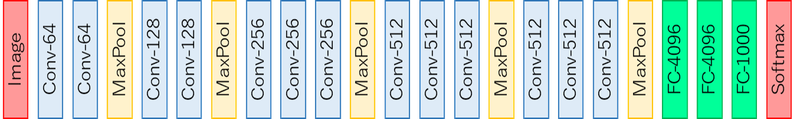

### 라이브러리 불러오기

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

### 데이터 준비

데이터셋: [개vs고양이](https://www.kaggle.com/c/dogs-vs-cats/data)
- 훈련 아카이브에는 개와 고양이의 이미지 25,000개가 포함되어 있다.
- 이 파일에 대해 알고리즘을 훈련하고 test1.zip에 대한 레이블을 예측합니다(1 = 개, 0 = 고양이)

### 데이터 불러오기

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

#### train 데이터와 validation 데이터에서 개와 고양이 이미지가 저장된 경로를 각각 변수에 저장

In [4]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/validation


In [5]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print(train_cats_dir)

# directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print(validation_dogs_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs


#### train, validation 데이터 개수

In [6]:
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

total training cat images: 1000
total training dog images: 1000


In [7]:
num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

total validation cat images: 500
total validation dog images: 500


In [8]:
total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

Total training images: 2000
Total validation images: 1000


#### 이미지 데이터 시각화

In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

### 파라미터 설정

In [10]:
batch_size = 16
epochs = 5
IMG_HEIGHT = 256
IMG_WIDTH = 256

## 데이터 증강(Data Augmentation)
기존의 데이터셋에 다양한 변형을 가하여 데이터의 양을 인위적으로 늘리는 기법

**이미지 데이터 증강 기법**

- 회전(Rotation): 이미지를 일정 각도로 회전시키는 방법
    - 모델이 다양한 각도에서의 객체를 인식할 수 있도록 도와준다.
    
- 이동(Translation)/시프트(Shift): 이미지를 수평 또는 수직 방향으로 이동시키는 기법
    - 모델이 위치의 변화에 강건하게 만든다.
    
- 크기 조절(Rescale): 이미지의 크기를 조절하는 방법
    - 크기가 변경되어도 객체를 인식할 수 있도록 모델을 훈련시킨다.
    
- 뒤집기(Flipping): 이미지를 수평 또는 수직으로 뒤집기
    - 모델이 방향 변화에도 불구하고 객체를 인식할 수 있게 도와준다.
    
- 크롭(Cropping): 이미지의 일부 영역을 잘라내어 사용하는 방법
    - 모델이 이미지의 일부분만으로도 전체를 이해할 수 있도록 훈련시킨다.
    
- 색상 변화(Color Jitter): 이미지의 밝기, 대비, 채도를 임의로 조절
    - 모델이 다양한 조명 조건과 환경에서도 객체를 인식할 수 있도록 한다.
    
- 노이즈 추가(Adding Noise): 이미지에 랜덤 노이즈를 추가
    - 모델이 노이즈가 있는 데이터에서도 robust하게 작동할 수 있도록 도와준다.
    
- 줌 인/아웃(Zoom In/Out): 이미지를 확대하거나 축소
    - 모델이 다양한 크기의 객체를 인식할 수 있게 한다.

In [11]:
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=False)

`.flow_from_directory`를 사용하여 파이프라인을 만들어 directory와 작업 환경을 연결시켜 준다.  
개와 고양이를 분류하는 task를 수행하기 때문에class_mode는 'binary'이다.  
Classification task에 따라 class_mode를 변경하시면 됩니다.

In [12]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


#### 데이터 증강 이미지 확인

In [13]:
train_data_gen[0][0].shape

(16, 256, 256, 3)

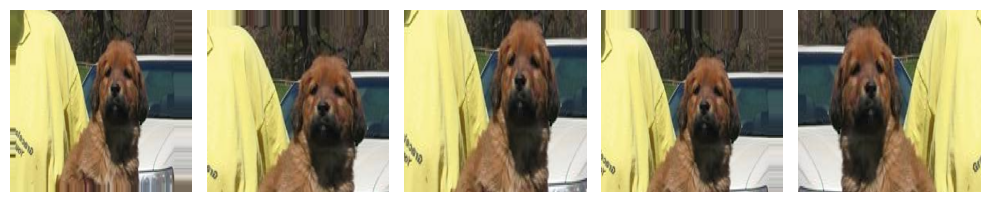

In [14]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Validation data generator

Validation 데이터에도 train 데이터와 같은 동일한 작업을 해준다.  
그러나 Validation 데이터는 classification이 잘 되는지 평가하는 용도로 사용되기 때문에 데이터의 스케일만 변경해 준다.

In [15]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [16]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


#### 데이터 증강 이미지 확인

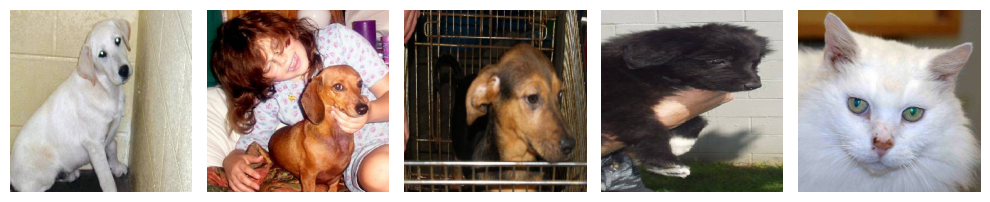

In [17]:
sample_training_images, _ = next(val_data_gen)
plotImages(sample_training_images[:5])

#### 정답 데이터

In [18]:
_[:5]

array([1., 1., 1., 1., 0.], dtype=float32)

## VGG16 모델 구현하기

이미지에 나온 VGG16 모델 구현  
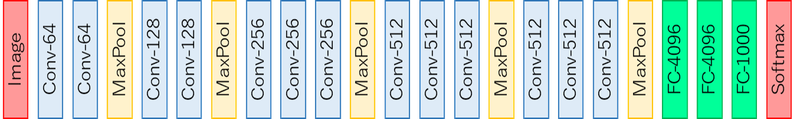

In [ ]:
input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(4096, activation='relu')(x)
x=tf.keras.layers.Dense(4096, activation='relu')(x)
out_layer=tf.keras.layers.Dense(1000, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 batch_normalization (Batch  (None, 256, 256, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856 

- 자꾸 커널이 죽기 때문에 모델을 줄였습니다.

In [ ]:
input_layer = tf.keras.layers.Input(shape=(256, 256, 3))
x = tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x = tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D((2, 2))(x)

x = tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D((2, 2))(x)

x = tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D((2, 2))(x)

x = tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D((2, 2))(x)

x = tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D((2, 2))(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)  # 유닛 수 감소
x = tf.keras.layers.Dense(1024, activation='relu')(x)  # 유닛 수 감소
out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 batch_normalization_5 (Bat  (None, 256, 256, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 128, 128, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 128)     7385

### 손실함수, optimizer, metric 설정

In [ ]:
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)
metric=tf.keras.metrics.binary_accuracy
callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]

model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

### 모델 학습

In [ ]:
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/5
125/125 [==============================] - 88s 522ms/step - loss: 18.9495 - binary_accuracy: 0.5355 - val_loss: 0.9090 - val_binary_accuracy: 0.5500
Epoch 2/5
125/125 [==============================] - 62s 492ms/step - loss: 0.6807 - binary_accuracy: 0.5540 - val_loss: 0.7051 - val_binary_accuracy: 0.5610
Epoch 3/5
125/125 [==============================] - 67s 534ms/step - loss: 0.7317 - binary_accuracy: 0.5740 - val_loss: 0.7763 - val_binary_accuracy: 0.5620
Epoch 4/5
125/125 [==============================] - 63s 500ms/step - loss: 0.6872 - binary_accuracy: 0.5485 - val_loss: 0.6785 - val_binary_accuracy: 0.5490
Epoch 5/5
125/125 [==============================] - 61s 489ms/step - loss: 0.6897 - binary_accuracy: 0.5475 - val_loss: 0.6765 - val_binary_accuracy: 0.5530


### 시각화

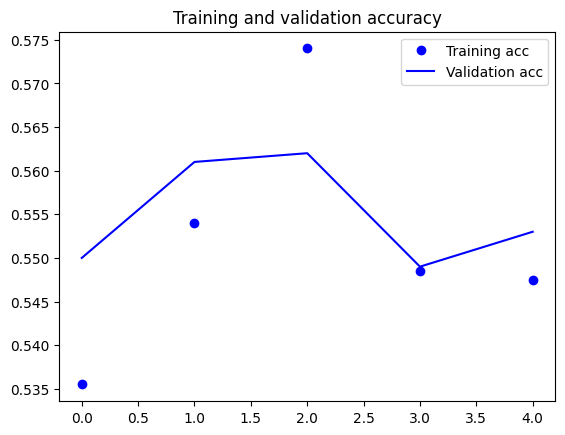

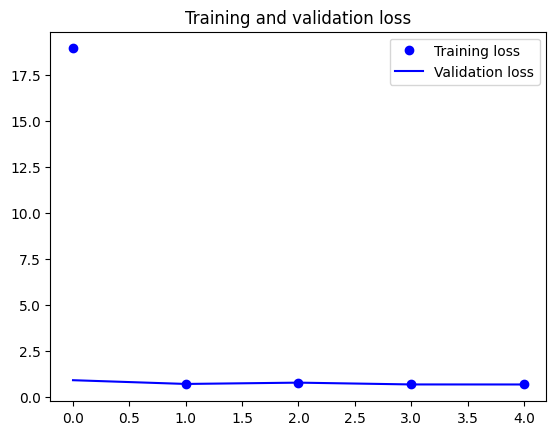

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 다양한 방법을 사용하여 모델의 성능 올리기
hyperparameter 변경, 모델 수정, optimizer 변경, skip connection, pre-trained model 등 다양한 방법을 사용하면 모델의 성능을 높일 수 있다.

### hyperparameter 변경



In [ ]:
batch_size = 64
epochs = 10
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [ ]:
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/10
31/31 [==============================] - 33s 1s/step - loss: 0.6943 - binary_accuracy: 0.4863 - val_loss: 0.6929 - val_binary_accuracy: 0.5010
Epoch 2/10
31/31 [==============================] - 29s 935ms/step - loss: 0.6941 - binary_accuracy: 0.4766 - val_loss: 0.6927 - val_binary_accuracy: 0.5000
Epoch 3/10
31/31 [==============================] - 29s 934ms/step - loss: 0.6933 - binary_accuracy: 0.4746 - val_loss: 0.6921 - val_binary_accuracy: 0.4990
Epoch 4/10
31/31 [==============================] - 28s 922ms/step - loss: 0.6938 - binary_accuracy: 0.4922 - val_loss: 0.6928 - val_binary_accuracy: 0.5010
Epoch 5/10
31/31 [==============================] - 29s 944ms/step - loss: 0.6938 - binary_accuracy: 0.4453 - val_loss: 0.6928 - val_binary_accuracy: 0.5010
Epoch 6/10
31/31 [==============================] - 29s 927ms/step - loss: 0.6937 - binary_accuracy: 0.4785 - val_loss: 0.6927 - val_binary_accuracy: 0.5010
Epoch 7/10
31/31 [==============================] - 28s 923ms

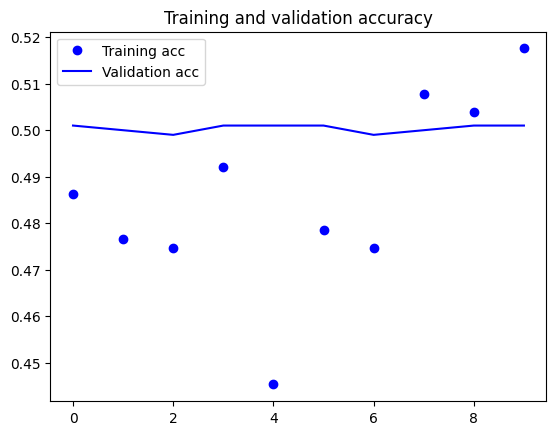

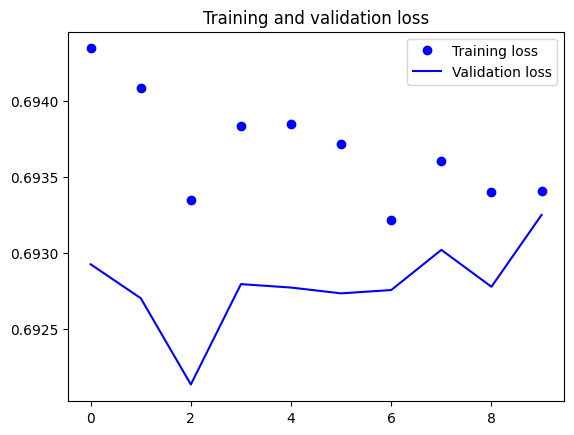

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 데이터 generator 변경

In [ ]:
batch_size = 64
epochs = 10
IMG_HEIGHT = 256
IMG_WIDTH = 256

Found 2000 images belonging to 2 classes.


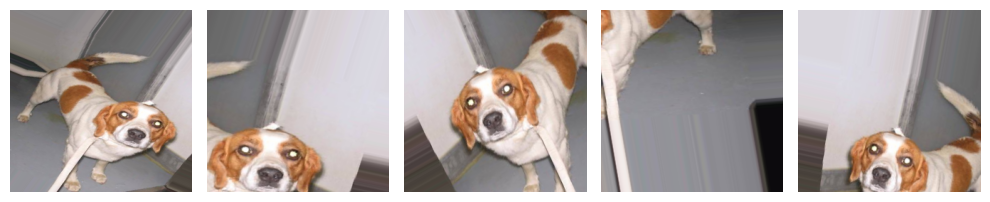

In [ ]:
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=30,
                                     width_shift_range=0.4,
                                     height_shift_range=0.4,
                                     zoom_range=0.4,
                                     horizontal_flip=True,
                                     vertical_flip=False)

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Found 1000 images belonging to 2 classes.


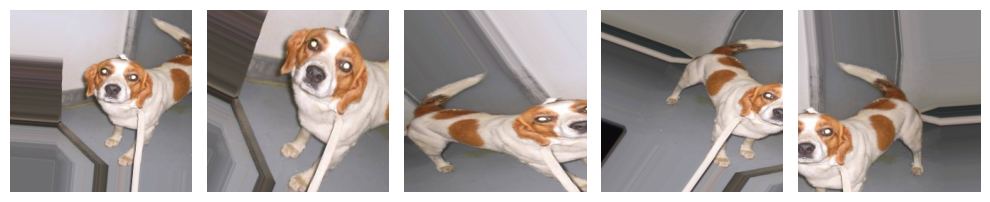

In [ ]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/10
31/31 [==============================] - 117s 2s/step - loss: 0.6960 - binary_accuracy: 0.4990 - val_loss: 0.6943 - val_binary_accuracy: 0.5000
Epoch 2/10
31/31 [==============================] - 70s 2s/step - loss: 0.6910 - binary_accuracy: 0.5000 - val_loss: 0.6929 - val_binary_accuracy: 0.5000
Epoch 3/10
31/31 [==============================] - 69s 2s/step - loss: 0.6920 - binary_accuracy: 0.5010 - val_loss: 0.6958 - val_binary_accuracy: 0.5020
Epoch 4/10
31/31 [==============================] - 65s 2s/step - loss: 0.6926 - binary_accuracy: 0.4935 - val_loss: 0.6922 - val_binary_accuracy: 0.5000
Epoch 5/10
31/31 [==============================] - 65s 2s/step - loss: 0.6926 - binary_accuracy: 0.5005 - val_loss: 0.6968 - val_binary_accuracy: 0.5000
Epoch 6/10
31/31 [==============================] - 64s 2s/step - loss: 0.6967 - binary_accuracy: 0.5005 - val_loss: 0.6929 - val_binary_accuracy: 0.5010
Epoch 7/10
31/31 [==============================] - 65s 2s/step - loss: 0.6

### 모델 수정

In [ ]:
batch_size = 64
epochs = 10
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [ ]:
input_layer = tf.keras.layers.Input(shape=(256, 256, 3))

# Convolutional Block 1
x = tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x = tf.keras.layers.MaxPool2D((2, 2))(x)

# Convolutional Block 2
x = tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPool2D((2, 2))(x)

# Convolutional Block 3
x = tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPool2D((2, 2))(x)

# Flatten and Dense Layers
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Dropout to prevent overfitting
out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create and compile model
model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_26 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 64, 128)       7385

In [ ]:
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)
metric=tf.keras.metrics.binary_accuracy
callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]

model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

In [ ]:
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/10
32/31 [==============================] - ETA: 0s - loss: 18.0723 - binary_accuracy: 0.5078

### pre-trained *model*

In [19]:
batch_size = 32
epochs = 10
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [20]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input

In [21]:
# 사전 훈련된 MobileNetV2 모델 로드, 마지막 분류 레이어는 제외
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # 기존 모델의 가중치는 고정

# 커스텀 레이어 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)  # 특성 맵을 하나의 벡터로 변환
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # 최종 분류 레이어 변경

# 최종 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 128, 128, 32)         0         ['bn_Conv1[0][0]']        

In [30]:
# 데이터 증강 적용
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,  # 훈련 데이터 디렉토리 경로
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'  # 이진 분류
)

Found 2000 images belonging to 2 classes.


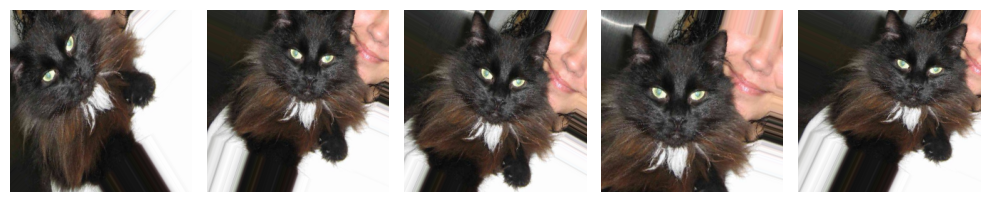

In [31]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [32]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    validation_dir,  # 검증 데이터 디렉토리 경로
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'
)

Found 1000 images belonging to 2 classes.


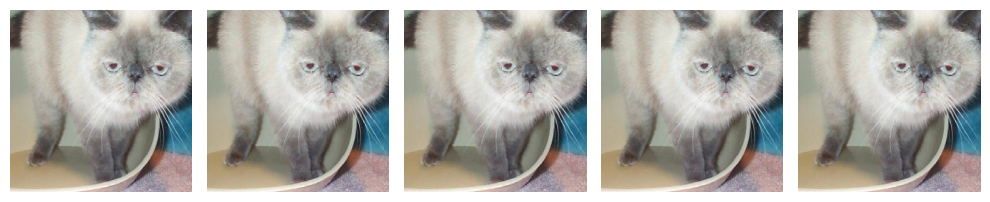

In [33]:
augmented_images = [val_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [29]:
callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]

history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/10
62/62 [==============================] - 150s 2s/step - loss: 0.1504 - accuracy: 0.9484 - val_loss: 0.0556 - val_accuracy: 0.9820
Epoch 2/10
62/62 [==============================] - 132s 2s/step - loss: 0.0876 - accuracy: 0.9692 - val_loss: 0.0505 - val_accuracy: 0.9820
Epoch 3/10
62/62 [==============================] - 124s 2s/step - loss: 0.0702 - accuracy: 0.9712 - val_loss: 0.0913 - val_accuracy: 0.9760
Epoch 4/10
62/62 [==============================] - 128s 2s/step - loss: 0.0802 - accuracy: 0.9782 - val_loss: 0.0697 - val_accuracy: 0.9780
Epoch 5/10
62/62 [==============================] - 142s 2s/step - loss: 0.0492 - accuracy: 0.9831 - val_loss: 0.0985 - val_accuracy: 0.9700
Epoch 6/10
62/62 [==============================] - 157s 3s/step - loss: 0.0513 - accuracy: 0.9841 - val_loss: 0.1214 - val_accuracy: 0.9650
Epoch 7/10
62/62 [==============================] - 158s 3s/step - loss: 0.0547 - accuracy: 0.9772 - val_loss: 0.0521 - val_accuracy: 0.9840
Epoch 8/10
62

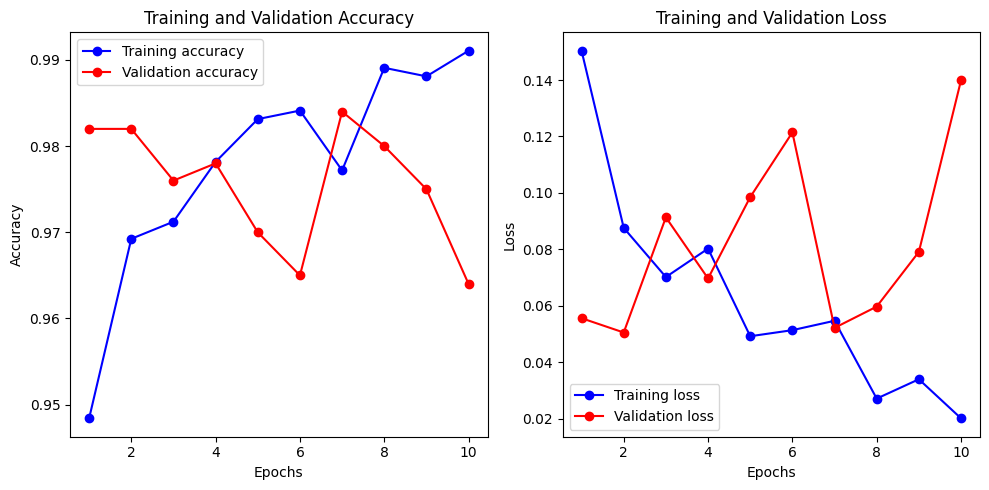

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# 정확도 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 손실 시각화
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 회고

주피터 노트북에서 GPU가 부족해서 실행이 안되길래 코랩으로 넘어와서 했는데  
세션이 자꾸 다운이 되다 보니까 이거 프로젝트 하나 돌리는데 엄청 오래 걸렸다.  

평소에 비해서 오래 걸렸다? 이생각이 들어서 그런 거 같다.  
역시 pre-trained model이 확실히 성능이 좋다.  

조금 더 공부를 해야하지만 음..그래도 일단?프로젝트를 했단 거에 만족한다!   